# Fechting the dataset 

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from SCFInitialGuess.utilities.analysis import matrix_error

figure_save_path = "/home/jo/Repos/MastersThesis/InitialGuess/Butadien/figures/"

mpl.style.use("seaborn")

In [3]:
S, P = np.load("../data/dataset.npy")

molecules = np.load("../data/molecules.npy")

dim = 26
p = list(P.reshape(-1, dim, dim))
s = list(S.reshape(-1, dim, dim))

s_test, p_test = s[150:], p[150:]

# Analyzing

In [4]:
from utilities.create_dataset import fetch_descriptor_values_over_time

mol = np.load("../data/molecules.npy")

distances, angles, dihedrals = fetch_descriptor_values_over_time(mol)


dihedrals[dihedrals < 2] += 2 * np.pi 
dihedrals[dihedrals > 5] -= 2 * np.pi 


In [5]:
labels_distances = [
    "C1-C2",
    "C2-C3",
    "C3-C4",
    "C1-H1",
    "C1-H2",
    "C2-H3",
    "C3-H4",
    "C4-H5",
    "C4-H6"
]

labels_angles = [
    "C1-C2-C3",
    "C2-C3-C4",
    "H1-C1-C2",
    "H2-C1-C2",
    "H3-C2-C1",
    "H4-C3-C4",
    "H5-C4-C3",
    "H6-C4-C3"
]

labels_dihedrals = [
    "C1-C2-C3-C4",
    "H1-C1-C2-C3",
    "H2-C1-C2-C3",
    "H3-C2-C3-C4",
    "H3-C3-C2-C1",
    "H5-C4-C2-C2",
    "H6-C4-C3-C2"
]

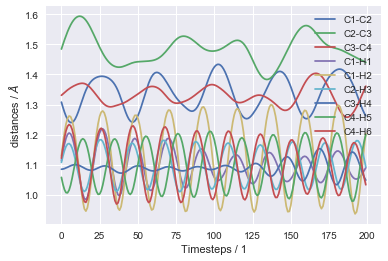

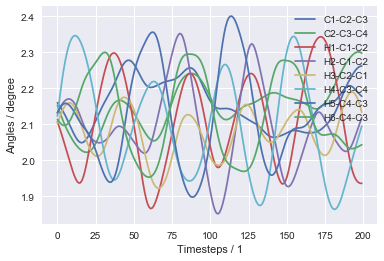

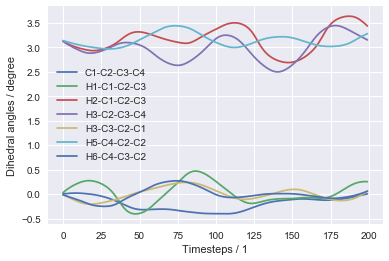

In [6]:
plt.figure()
for i in range(distances.shape[1]):
    plt.plot(distances[:, i], label=labels_distances[i])
plt.legend()
plt.xlabel("Timesteps / 1")
plt.ylabel(r"distances / $\AA$")
plt.savefig(figure_save_path + "DatasetButadienDistances.png")
    
plt.figure()
for i in range(angles.shape[1]):
    plt.plot(angles[:, i], label=labels_angles[i])
plt.ylabel(r"Angles / degree")
plt.xlabel("Timesteps / 1")
plt.legend()
plt.savefig(figure_save_path + "DatasetButadienAngles.png")
    
plt.figure()
for i in range(dihedrals.shape[1]):
    plt.plot(dihedrals[:, i], label=labels_dihedrals[i])
plt.ylabel("Dihedral angles / degree")
plt.xlabel("Timesteps / 1")
plt.legend()
plt.savefig(figure_save_path + "DatasetButadienDihedrals.png")

plt.show()

## HF Groudstate energy:

In [5]:
from SCFInitialGuess.utilities.analysis import measure_hf_energy

energy = list(measure_hf_energy(p, list(map(lambda x: x.get_pyscf_molecule(), molecules))))

Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs sys.args
Warn: Ipython shell catchs s

Text(0,0.5,'HF Energy / $\\AA$')

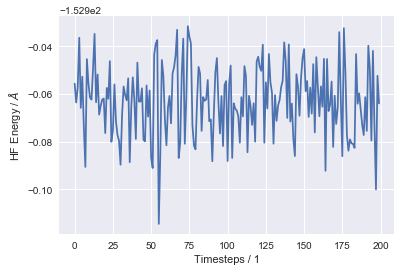

In [6]:
plt.figure()
plt.plot(energy)
plt.xlabel("Timesteps / 1")
plt.ylabel(r"HF Energy / Hartree")
#plt.savefig(figure_save_path + "DatasetButadienDistances.png")

# Check for symmetry

In [7]:
def symmetry_error(M):
    
    error = np.zeros(M[0].shape)
    for m in M:
        error += np.abs(m - np.transpose(m))
        
    return error / len(M)

## S -Matrix

0.0


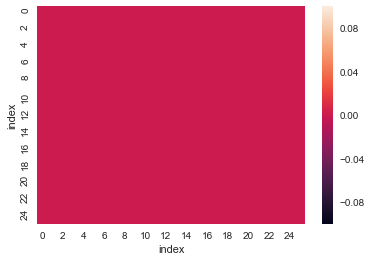

In [8]:
error = symmetry_error(s)
print(np.mean(error))
matrix_error(error)
plt.show()

## P-Matrix

1.4685232740647556e-18


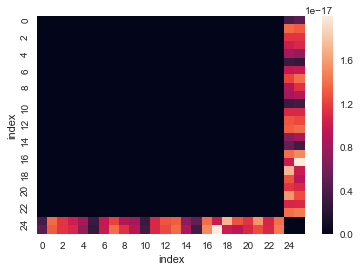

In [9]:
error = symmetry_error(p)
print(np.mean(error))
matrix_error(error)
plt.show()

# Verrauschte p matix

0.001084426017166272


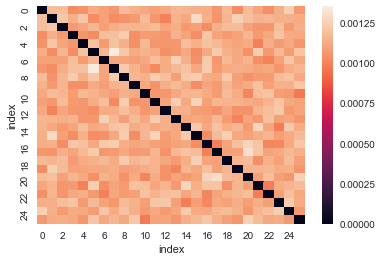

In [10]:
p_noise = list((P + np.random.randn(*P.shape) * 1e-3).reshape(-1, dim, dim))
error = symmetry_error(p_noise)
print(np.mean(error))
matrix_error(error)
plt.show()

In [15]:
errors = []
for p_i in p_test:
    errors.append(p_i - p_i.T)

print(np.mean(errors), np.std(errors))

0.0 6.962975119625888e-18


# Idempotency

$$PSP^T-2P=0$$,
Faktor 2 wegen Definition/Besetzung

In [7]:
def idempotency_error(M):
    
    error = np.zeros(M[0].shape)
    for m in M:
        error += np.abs(m - np.dot(m, m))
        
    return error / len(M)

def weighted_idempotency_eror(M, W):
    
    error = np.zeros(M[0].shape)
    for m, w in zip(M, W):
        error += np.abs(2 * m - np.dot(m, np.dot(w, m)))
        
    return error / len(M)
    

In [8]:
def mc_wheeny_purification(p,s):
    p = p.reshape(dim, dim)
    s = s.reshape(dim, dim)
    return (3 * np.dot(np.dot(p, s), p) - np.dot(np.dot(np.dot(np.dot(p, s), p), s), p)) / 2

def mc_wheeny_purification_2(p, s=None):
    p = p.reshape(dim, dim)
    return 3 * np.dot(p, p) - 2 * np.dot(np.dot(p, p), p)

def idemp_error(p, s):
    p = p.reshape(dim, dim)
    s = s.reshape(dim, dim)
    return np.mean((np.abs(p @ s @ p.T - 2 * p)))


    
    
                   

## P matrix

3.24719630914608e-16


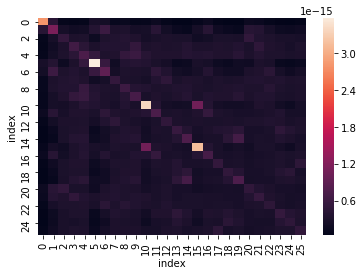

In [9]:
error = weighted_idempotency_eror(p, s)
print(np.mean(error))
matrix_error(error)
plt.show()

## P matrix w/ noise

0.0011664983574595186


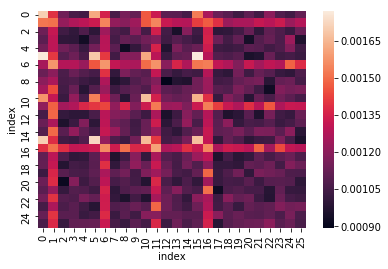

In [10]:
error = weighted_idempotency_eror(p_noise, s)
print(np.mean(error))
matrix_error(error)
plt.show()

In [17]:
from functools import reduce

errors = []
for s_i, p_i in zip(s_test, p_test):
    errors.append(2 * p_i - reduce(np.dot, (p_i, s_i, p_i.T)))

print(np.mean(errors), np.std(errors))

-7.215399790291557e-19 4.484844750879484e-16


# Check occupancy
$$tr(PS) = N_{electrons}$$

In [26]:
def population(S, P):
    for i, (s,p) in enumerate(zip(S, P)):
        yield np.trace(np.dot(p, s))


## Normal

In [27]:
print(np.mean(list(population(s, p))))

30.0


## Verrauscht

In [28]:
print(np.mean(list(population(s, p_noise))))

29.999669494459816
